In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL

import vgg16

In [2]:
tf.__version__

'1.8.0'

In [3]:
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


In [4]:
# Some helper functions

def load_image(file, size = (224,224)):
    image = PIL.Image.open(file)
    image = image.resize(size)
    return np.array(image)


def save_image(img,file_name):
    image = img.clip(0.0,255.0)
    # Converting to byte
    image = image.astype(np.uint8)
    
    with open(file_name,'wb') as write_file:
        PIL.Image.fromarray(image).save(write_file,'jpeg')


def plot_single(image, fig_size = (7,7)):
    fig = plt.figure(figsize = fig_size)
    plt.imshow(image.astype(int))
    plt.axis('off')
    
def plot_images(content_image,style_image, mixed_image):
    fig = plt.figure(figsize = (10,10))
    images = [content_image,style_image,mixed_image]
    title_list = ['Content Image','Style Image', 'Mixed Image']
    for i in range(3):
        ax = plt.subplot(1,3,i+1)
        plt.imshow(images[i].astype(int), interpolation='nearest')
        plt.title(title_list[i])
        plt.axis('off')
    plt.show()

In [5]:
# Mean Squared Error

def mean_squared_error(tensor1, tensor2):
    return tf.reduce_mean(tf.square(tensor1-tensor2))

In [6]:
# Content Loss Function

def get_content_loss(sess,model,content_image,layer_id):
    content_feed_dict = model.create_feed_dict(image = content_image)
    layers = model.get_layer_tensors(layer_id)
    
    content_outputs = sess.run(layers,feed_dict = content_feed_dict)
    
    with model.graph.as_default():
        layer_content_loss = []
        
        for layer,content in zip(layers,content_outputs):
            content_const = tf.constant(content)
            content_loss = mean_squared_error(layer,content_const)
            
            layer_content_loss.append(content_loss)
        
        avg_content_loss = tf.reduce_mean(layer_content_loss)

    return avg_content_loss

In [7]:
#Style Loss Function

def Gram_matrix(tensor):
    matrix = tf.reshape(tensor,shape = [-1,int(tensor.get_shape()[3])])
    gram_mat = tf.matmul(tf.transpose(matrix),matrix)
    return gram_mat

def get_style_loss(sess,model,style_image,layer_id):
    style_feed_dict = model.create_feed_dict(image = style_image)
    layers = model.get_layer_tensors(layer_id)
    
    with model.graph.as_default():
        layer_style_loss = []
        gram_mat_layers = [Gram_matrix(layer) for layer in layers]
        style_outputs = sess.run(gram_mat_layers, feed_dict = style_feed_dict)
        
        for layer,style in zip(gram_mat_layers,style_outputs):
            style_const = tf.constant(style)
            style_loss = mean_squared_error(layer,style_const)

            layer_style_loss.append(style_loss)
            
        avg_style_loss = tf.reduce_mean(layer_style_loss)
    return avg_style_loss

In [8]:
# Denoise loss function to reduce noise

def get_denoise_loss(model):
    
    noisy_loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
                 tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))
    return noisy_loss

In [14]:
# Implementing the Style Transfer Algorithm

def Style_Transfer(content_image,style_image,
                   content_layer_ids,style_layer_ids,
                  content_weight = 1.5, style_weight = 10.0,
                  denoise_weight = 0.3, num_epochs = 120, step_size = 10.0):
    
    model = vgg16.VGG16()
    sess = tf.InteractiveSession(graph = model.graph)
    
    print('Content Layers:')
    print(model.get_layer_names(content_layer_ids))
    print('\nStyle Layers:')
    print(model.get_layer_names(style_layer_ids))
    
    content_loss = get_content_loss(sess,model,content_image,content_layer_ids)
    style_loss = get_style_loss(sess,model,style_image,style_layer_ids)
    denoise_loss = get_denoise_loss(model)
    
    # Adjusting the values of the loss functions
    
    adjust_content = tf.Variable(1e-10,name = 'adjust_content')
    adjust_style = tf.Variable(1e-10,name = 'adjust_style')
    adjust_denoise = tf.Variable(1e-10,name = 'adjust_denoise')
    
    sess.run([adjust_content.initializer, adjust_style.initializer, adjust_denoise.initializer])
    
    upd_adj_content = adjust_content.assign(1.0/(content_loss + 1e-10))
    upd_adj_style = adjust_style.assign(1.0/(style_loss + 1e-10))
    upd_adj_denoise = adjust_denoise.assign(1.0/(denoise_loss + 1e-10))
    
    total_loss = content_weight * adjust_content * content_loss + \
                 style_weight * adjust_style * style_loss + \
                 denoise_weight * adjust_denoise * denoise_loss
            
    gradients = tf.gradients(total_loss,model.input)
    update_list = [gradients,upd_adj_content,upd_adj_style,upd_adj_denoise]
    
    
    mixed_image = np.random.rand(*content_image.shape) + 128
    
    for epoch in range(num_epochs):
        feed_dict = model.create_feed_dict(mixed_image)
        grad, adj_content_val, adj_style_val, adj_denoise_val = sess.run(update_list, feed_dict=feed_dict)
        grad = np.squeeze(grad)
        step_size_adj = step_size/(np.std(grad)+1e-8)
        mixed_image -= grad*step_size_adj
        mixed_image = np.clip(mixed_image,0.0,255.0)
        
        print(". ", end = "")
        
        if epoch%10 == 0:
            print()
            print(f'Epoch:{epoch}')
            plot_images(content_image,style_image,mixed_image)
            
    
    print()
    print('Final Image:')
    plot_single(mixed_image)    
    sess.close()
    return mixed_image

In [15]:
content_filename = '../../../Tensorflow/TensorFlow-Tutorials/images/willy_wonka_old.jpg'
content_image = load_image(content_filename)

In [16]:
style_filename = '../../../Tensorflow/TensorFlow-Tutorials/images/style2.jpg'
style_image = load_image(style_filename)

In [17]:
content_layer_ids = [4]
style_layer_ids = list(range(13))

/Users/Maverick/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Content Layers:
['conv3_1/conv3_1']

Style Layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']
. 
Epoch:0


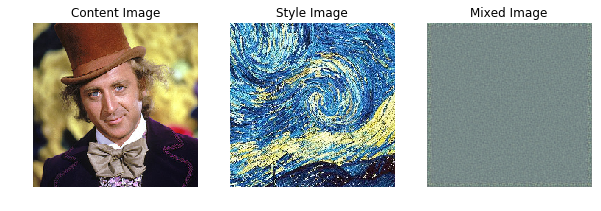

. . . . . . . . . . 
Epoch:10


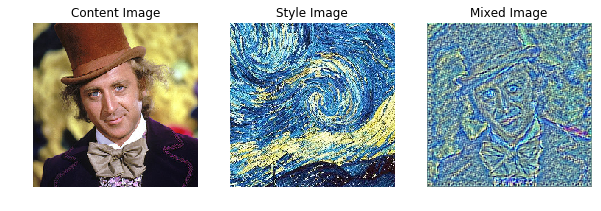

. . . . . . . . . . 
Epoch:20


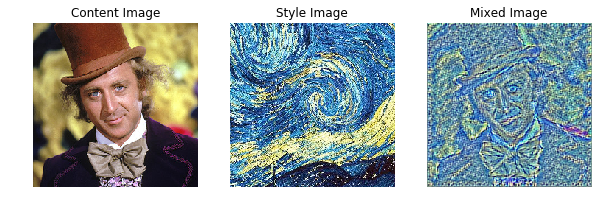

. . . . . . . . . . 
Epoch:30


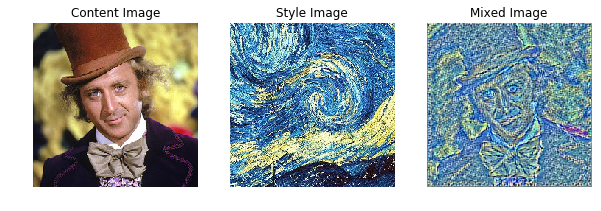

. . . . . . . . . . 
Epoch:40


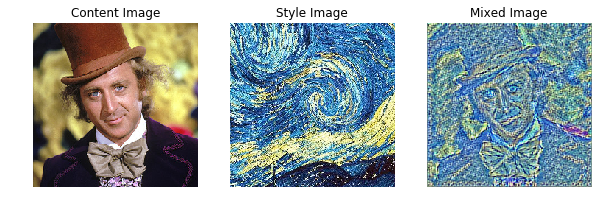

. . . . . . . . . . 
Epoch:50


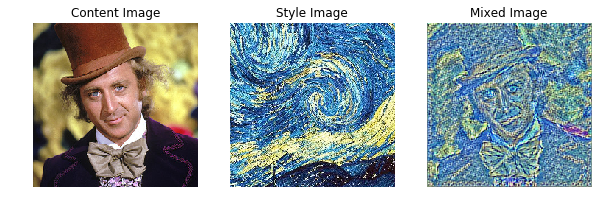

. . . . . . . . . 
Final Image:
CPU times: user 4min 41s, sys: 49.8 s, total: 5min 31s
Wall time: 1min 5s


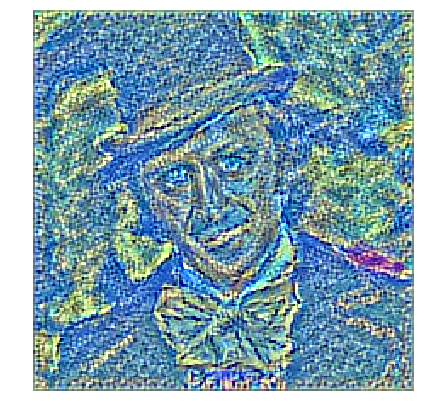

In [18]:
%%time
img = Style_Transfer(content_image,
                     style_image,
                     content_layer_ids,
                     style_layer_ids,
                     1.5,
                     10.0,
                     0.3,
                     60,
                     10.0)

#### Running it on portraits

In [45]:
content_filename = './data/top-gun.jpg'
content_image = load_image(content_filename)

In [46]:
style_filename = './data/style1.jpg'
style_image = load_image(style_filename)

In [47]:
content_layer_ids = [4]
style_layer_ids = list(range(13))

/Users/Maverick/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Content Layers:
['conv3_1/conv3_1']

Style Layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']
. 
Epoch:0


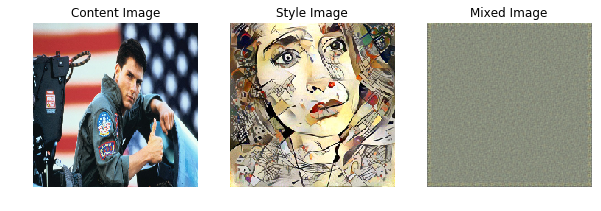

. . . . . . . . . . 
Epoch:10


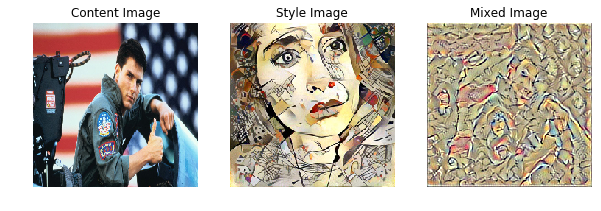

. . . . . . . . . . 
Epoch:20


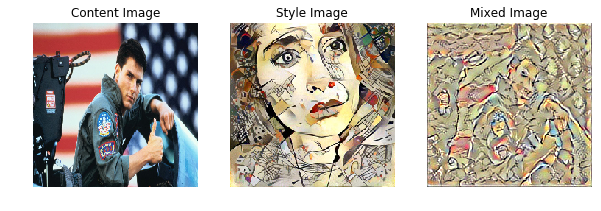

. . . . . . . . . . 
Epoch:30


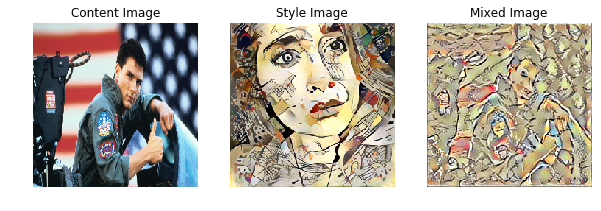

. . . . . . . . . . 
Epoch:40


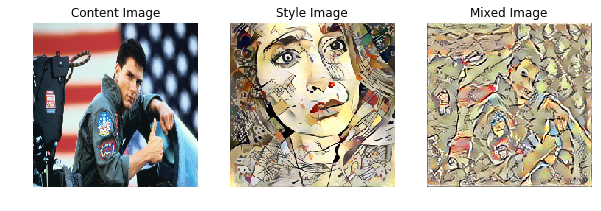

. . . . . . . . . . 
Epoch:50


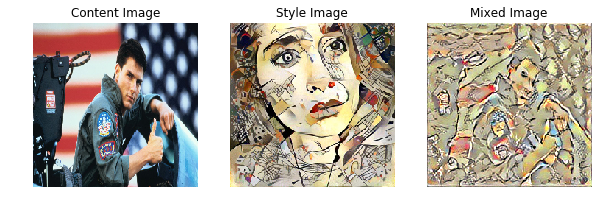

. . . . . . . . . 
Final Image:
CPU times: user 4min 31s, sys: 52.2 s, total: 5min 23s
Wall time: 1min 5s


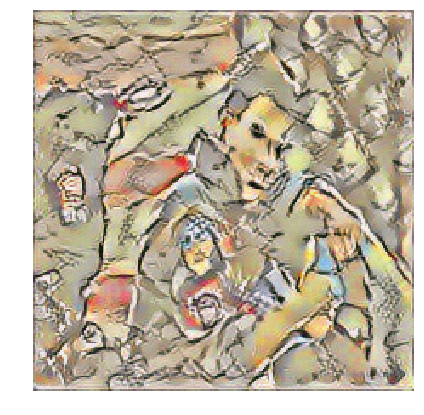

In [48]:
%%time
img = Style_Transfer(content_image,
                     style_image,
                     content_layer_ids,
                     style_layer_ids,
                     1.5,
                     10.0,
                     0.3,
                     60,
                     10.0)

<b> Next thing: Reduce the weight of the style image
    try different parameters